In [1]:
import sys; sys.path.append('..')

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skl
import torch.linalg as lin

## LQR with deterministic dynamics

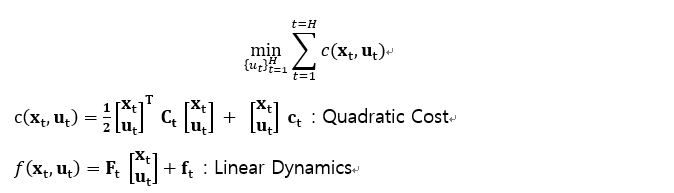

위에 기술된 최적화 문제는

환경 $f(\textbf{x}_t, \textbf{u}_t)$ 가 선형(Linear)이고, Cost function이 Quadratic 형태입니다. LQR 수업에서 배웠던 수식과 동일하게 구성이 되어 있습니다.

$\textbf{x}_t$는 시점 $t$에서 시스템의 상태를 나타냅니다. $\textbf{u}_t$는 시점 $t$에서의 행동, 혹은 시스템에 넣어주는 저희의 action을 표현하는 벡터입니다. $\textbf{C}_t\ 와\  \textbf{c}_t$ 는 각각 cost fucntion에서 2차항과 1차항의 계수입니다. $\textbf{F}_t \ 와 \ \textbf{f}_t$ 는 Linear Dynamics의 계수들입니다.

위의 수식에서는 시간에 따른 가변성이 있을 수도 있어 다음과 같이 $t$를 첨자로 두었으나, 저희가 구현할 문제에 대해서는 시간에 invariant하다고 가정을 할 것입니다.

다음과 같은 문제를 효율적으로 풀 수 있는 기법 중 하나인 LQR을 구현해볼 것입니다.

## optimization 문제 기본 setting

우선 LQR 알고리즘을 구현하기 이전에 문제의 기본 세팅을 하겠습니다. 
state, action의 dimension 그리고 cost function, linear Dynamics의 계수를 세팅하겠습니다.

(각 계수들은 미리 정해두었습니다. 위의 주석은 계수에 대한 기본 설명, 행렬의 크기입니다.)

In [66]:
state_dim = 2 # state dimension
action_dim = 3 # action dimension

T = 20

# Cost function's coefficient of second order term 
# matrix shape [(state_dim + action_dim) * (state_dim + action_dim)]
C = torch.eye(n=(state_dim + action_dim))

# Cost function's coefficient of first order term
# matrix shape [(state_dim + action_dim), 1)]
c = torch.rand(size=(state_dim + action_dim, 1))

# Linear Dynamics's coefficient of first order term
# matrix shape [state_dim * (state_dim + action_dim)]
F = torch.rand(size=(state_dim, state_dim + action_dim))

# Linear Dynamics's coefficient of constant term
# matrix shape[1 * state_dim]
f = torch.zeros(size=(state_dim, 1))

# dictionary of K
Large_K = dict()
small_k = dict()

# dictionary of V
Large_V = dict()
small_v = dict()

# dictionary of Q
Large_Q = dict()
small_q = dict()

## 시점 T에서 LQR을 통한 최적 행동의 계수 K 구하기

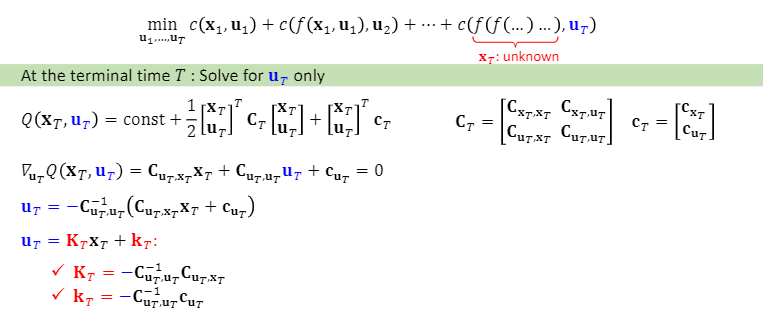

강의에서 보셨던 것처럼 $\textbf{K}_T \ 와 \ \textbf{k}_T$ 를 구하고, 그 값을 바탕으로 시점 $T$에서의 optimal한 action, $\textbf{u}_T$ 를 구할 수 있습니다.

$\textbf{u}_T$의 계산을 위해 필요한 계수를 구하고, 그 값들을 dictionary에 저장하도록 하겠습니다

(추후에 forward 과정을 위해서 필요하기 때문!!!!)

In [67]:
K_T =  - torch.matmul(torch.linalg.inv(C[:action_dim, :action_dim]), C[state_dim:, :state_dim])
k_T = - torch.matmul(torch.linalg.inv(C[state_dim:,  state_dim:]), c[state_dim:, :])

In [68]:
print("K_T:  ", K_T)
print("k_T:  ", k_T)

Large_K[T] = K_T
small_k[T] = k_T

K_T:   tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.]])
k_T:   tensor([[-0.6792],
        [-0.1041],
        [-0.4230]])


### 함수화

In [69]:
def calculate_K(Q, q, state_dim, action_dim):
    K_t =  - torch.matmul(torch.linalg.inv(Q[:action_dim, :action_dim]), Q[state_dim:, :state_dim])
    k_t = - torch.matmul(torch.linalg.inv(Q[state_dim:,  state_dim:]), q[state_dim:, :])
    
    return K_t, k_t
    

## 시점 T에서의 최적 행동을 바탕으로 cost 계산

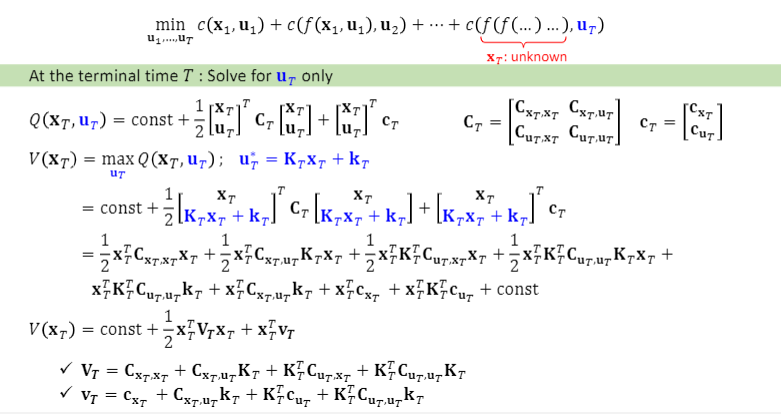

앞서 구한 action $\textbf{u}_T$를 objective의 cost function에 대입하여 $Q((\textbf{x}_t, \textbf{u}_t)$를 $V(\textbf{x}_t)$로 상태변수 $\textbf{x}_t$ 만을 인자로 가지는 함수로 바꿀 수 있습니다.

In [70]:
V_T = C[:state_dim, state_dim] + torch.matmul(C[:state_dim, state_dim:], Large_K[T]) + torch.matmul(Large_K[T].T, C[state_dim:, :state_dim]) + torch.matmul(torch.matmul(Large_K[T].T, C[state_dim:, state_dim:]), Large_K[T])
v_T = c[:state_dim, :] + torch.matmul(C[:state_dim, state_dim:], small_k[T]) + torch.matmul(Large_K[T].T, c[state_dim:, :]) + torch.matmul(torch.matmul(Large_K[T].T, C[state_dim:, state_dim:]), small_k[T])

In [71]:
print("V_T:  ", V_T)
print("v_T:  ", v_T)

Large_V[T] = V_T
small_v[T] = v_T

V_T:   tensor([[0., 0.],
        [0., 0.]])
v_T:   tensor([[0.5541],
        [0.9101]])


### 함수화

In [72]:
def calculate_V(C, state_dim, action_dim, Large_K, small_k, t):
    V_t = C[:state_dim, state_dim] + torch.matmul(C[:state_dim, state_dim:], Large_K[t]) + torch.matmul(Large_K[t].T, C[state_dim:, :state_dim]) + torch.matmul(torch.matmul(Large_K[t].T, C[state_dim:, state_dim:]), Large_K[t])
    v_t = c[:state_dim, :] + torch.matmul(C[:state_dim, state_dim:], small_k[t]) + torch.matmul(Large_K[t].T, c[state_dim:, :]) + torch.matmul(torch.matmul(Large_K[t].T, C[state_dim:, state_dim:]), small_k[t])
    
    return V_t, v_t

## 시점 T-1 에서의 cost를 $\textbf{x}_{t-1}, \ \textbf{u}_{t-1}$ 로 표현

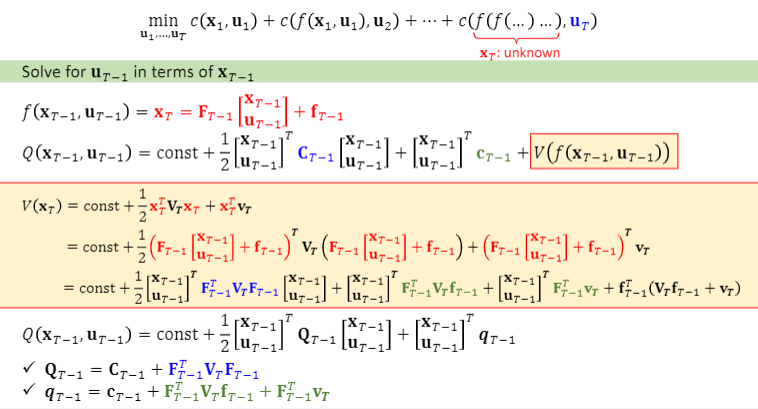

C와 F는 time-invariant 한 coefficient이고, $\textbf{V}_T\ 와 \ \textbf{v}_T $는 이전 셀에서 구했습니다.

In [73]:
Q_t = C + torch.matmul(torch.matmul(F.T, Large_V[T]), F)
q_t = c + torch.matmul(torch.matmul(F.T, Large_V[T]), f) + torch.matmul(F.T, small_v[T])

In [74]:
Large_Q[T-1] = Q_t
small_q[T-1] = q_t

### 함수화

In [75]:
def calculate_Q(C, c, Large_V, small_v, F, f, t):
    Q_t = C + torch.matmul(torch.matmul(F.T, Large_V[t+1]), F)
    q_t = c + torch.matmul(torch.matmul(F.T, Large_V[t+1]), f) + torch.matmul(F.T, small_v[t+1])
    
    return Q_t, q_t

## Backword recursion 시점 T=0 까지 진행

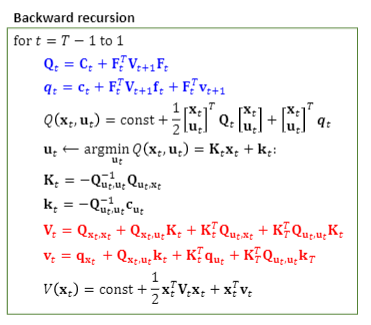

위의 3가지 과정을 시점 T-1, T-2, ... , 1 까지 반복하여 coefficient(V, K, Q)를 구하고 저장합니다. 

In [76]:
T = 20

state_dim=2
action_dim=3

C = torch.randn(size=(state_dim + action_dim, state_dim + action_dim))
c = torch.randn(size=(state_dim + action_dim, 1))
F = torch.randn(size=(state_dim, state_dim + action_dim))
f = torch.randn(size=(state_dim, 1))

K_t, k_t = calculate_K(C, c, state_dim, action_dim)

Large_K[T] = K_t
small_k[T] = k_t

V_t, v_t = calculate_V(C, state_dim, action_dim, Large_K, small_k, T)
Large_V[T] = V_t
small_v[T] = v_t

for time in range(T-1, 0, -1):
    
    # calculate Q
    Q_t, q_t = calculate_Q(C, c, Large_V, small_v, F, f, time)
    Large_Q[time] = Q_t
    small_q[time] = q_t
    
    K_t, k_t = calculate_K(Q_t, q_t, state_dim, action_dim)
    Large_K[time] = K_t
    small_k[time] = k_t
    
    V_t, v_t = calculate_V(C, state_dim, action_dim, Large_K, small_k, time)
    Large_V[time] = V_t
    small_v[time] = v_t

In [77]:
### 함수화

In [78]:
def backward_recursion(state_dim, action_dim, C, c, F, f, T):
    
    # dictionary of K
    Large_K = dict()
    small_k = dict()

    # dictionary of V
    Large_V = dict()
    small_v = dict()

    # dictionary of Q
    Large_Q = dict()
    small_q = dict()
    
    K_t, k_t = calculate_K(C, c, state_dim, action_dim)

    Large_K[T] = K_t
    small_k[T] = k_t

    V_t, v_t = calculate_V(C, state_dim, action_dim, Large_K, small_k, T)
    Large_V[T] = V_t
    small_v[T] = v_t

    for time in range(T-1, 0, -1):

        # calculate Q
        Q_t, q_t = calculate_Q(C, c, Large_V, small_v, F, f, time)
        Large_Q[time] = Q_t
        small_q[time] = q_t

        K_t, k_t = calculate_K(Q_t, q_t, state_dim, action_dim)
        Large_K[time] = K_t
        small_k[time] = k_t

        V_t, v_t = calculate_V(C, state_dim, action_dim, Large_K, small_k, time)
        Large_V[time] = V_t
        small_v[time] = v_t
        
    return (Large_Q, small_q), (Large_K, small_k), (Large_V, small_v)

In [79]:
backward_recursion(state_dim, action_dim, C, c, F, f, T)

(({19: tensor([[ -7.2114,   9.3796, -13.8205, -16.7595,  -8.0525],
           [ -6.1069,  -2.3194,  -2.5992,   2.0489,   1.5951],
           [  0.3286,   8.4808,  -9.8576, -18.6274,  -5.3353],
           [  3.7511,   7.4117,  -3.8462, -11.8412,  -2.2788],
           [ -0.5819,   4.3186,  -6.6435, -11.1626,  -3.3388]]),
   18: tensor([[-4.5793,  3.5645, -5.7455, -5.4055, -3.4060],
           [-1.7144,  0.5318, -2.1922, -1.1903,  1.8907],
           [-2.2212,  1.0453, -4.0773, -6.5327, -2.0731],
           [-2.9327, -0.0087, -1.2577, -1.4666, -0.8978],
           [-1.9992, -0.0088, -3.2282, -4.0962, -1.4100]]),
   17: tensor([[ -0.4397,   6.9856,  -6.1260,  -9.7553,  -3.5635],
           [-14.5069,  -5.2040,  -6.0504,   3.7054,  -0.4956],
           [ 14.2743,   9.6439,  -0.3538, -14.9703,   0.2897],
           [ 21.3682,  11.5284,   5.4041, -11.8994,   3.2544],
           [  7.4749,   4.9479,  -1.1086,  -8.9745,  -0.0638]]),
   16: tensor([[ 21.5933,  15.6457,   1.7879, -16.0334,   1.27

## forward recursion 진행


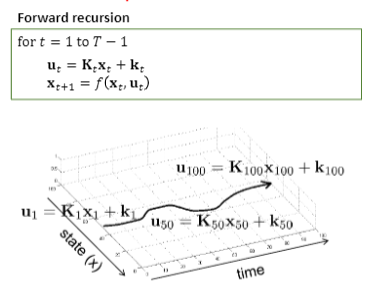

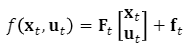

In [80]:
x_dict = dict()
u_dict = dict()

x0 = torch.randn(size=(state_dim, 1))
x_dict[1] = x0

for time in range(1, T):
    
    u_t = torch.matmul(Large_K[time], x_dict[time]) + small_k[time]
    u_dict[time] = u_t
    
    next_x = torch.matmul(F, torch.cat([x_dict[time], u_t], dim=0)) + f
    x_dict[time+1] = next_x

### 함수화

In [81]:
def forward_recursion(x0, Large_K, small_k, F, f, T):
    x_dict = dict()
    u_dict = dict()
    
    x_dict[1] = x0

    for time in range(1, T):

        u_t = torch.matmul(Large_K[time], x_dict[time]) + small_k[time]
        u_dict[time] = u_t

        next_x = torch.matmul(F, torch.cat([x_dict[time], u_t], dim=0)) + f
        x_dict[time+1] = next_x
        
    return x_dict, u_dict

In [82]:
forward_recursion(x0, Large_K, small_k, F, f, T)





({1: tensor([[-0.4633],
          [-0.4883]]),
  2: tensor([[ 1.7547],
          [-5.0991]]),
  3: tensor([[-5.2888],
          [ 8.5339]]),
  4: tensor([[ 17.6196],
          [-36.6424]]),
  5: tensor([[-56.4335],
          [108.7207]]),
  6: tensor([[ 183.2981],
          [-362.4130]]),
  7: tensor([[-592.6722],
          [1161.9697]]),
  8: tensor([[ 1920.5438],
          [-3774.9197]]),
  9: tensor([[-6217.7896],
          [12214.3994]]),
  10: tensor([[ 20079.5332],
          [-39490.5703]]),
  11: tensor([[-64687.2227],
          [127237.3125]]),
  12: tensor([[ 209814.3281],
          [-411457.2500]]),
  13: tensor([[-692670.0000],
          [1351903.5000]]),
  14: tensor([[ 2284455.7500],
          [-4478700.0000]]),
  15: tensor([[-6987994.5000],
          [14112827.0000]]),
  16: tensor([[ 17990738.],
          [-37912704.]]),
  17: tensor([[-45255244.],
          [ 95689848.]]),
  18: tensor([[ 19389184.],
          [-68406744.]]),
  19: tensor([[-21660870.],
          [-435